## 1. Install and import all dependencies

In [1]:
# Trading environment
import pytz
import gym
import MetaTrader5 as mt5
from gym_mtsim.metatrader import api
from gym_mtsim import (Timeframe, SymbolInfo, MtSimulator, 
                       OrderType, Order, SymbolNotFound, 
                       OrderNotFound, MtEnv)

# Processing
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

# Algorithms
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv # Vector hoá môi trường trading
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback

## 2. Preprocess data

In [2]:
# Load Data
data_path = 'XAUUSD_mt5_bars2022-2023.csv'
df = pd.read_csv(data_path)

In [3]:
df.head(5)

,Date,Timestamp,Open,High,Low,Close,TickCount,Volume,Spread
0,20220906,00:00:00,1713.928,1714.024,1713.836,1713.858,99,99,204
1,20220906,00:01:00,1713.858,1713.858,1713.534,1713.664,98,98,218
2,20220906,00:02:00,1713.638,1713.704,1713.524,1713.614,98,98,362
3,20220906,00:03:00,1713.584,1713.584,1713.478,1713.508,60,60,358
4,20220906,00:04:00,1713.498,1713.704,1713.488,1713.578,92,92,312


#### Biểu đồ

In [4]:
# Biểu đồ 2000 dòng đầu tiên
t = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Timestamp'], format='%Y%m%d %H:%M:%S')
fig = go.Figure(data=[go.Candlestick(x=t[:2000],
                open=df['Open'][:2000],
                high=df['High'][:2000],
                low=df['Low'][:2000],
                close=df['Close'][:2000])])
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

c:\Users\Nomocp\.virtualenvs\Algorithm_Trading-8sCfMenu\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


#### Kiểm tra thuộc tính dữ liệu

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354471 entries, 0 to 354470
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       354471 non-null  int64  
 1   Timestamp  354471 non-null  object 
 2   Open       354471 non-null  float64
 3   High       354471 non-null  float64
 4   Low        354471 non-null  float64
 5   Close      354471 non-null  float64
 6   TickCount  354471 non-null  int64  
 7   Volume     354471 non-null  int64  
 8   Spread     354471 non-null  int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 24.3+ MB


In [6]:
df.describe()

,Date,Open,High,Low,Close,TickCount,Volume,Spread
count,3.544710e+05,354471.000000,354471.000000,354471.000000,354471.000000,354471.000000,354471.000000,354471.000000
mean,2.022745e+07,1864.318147,1864.572102,1864.065539,1864.319242,120.534975,120.534975,287.936957
std,4.399606e+03,115.613384,115.604108,115.620486,115.612380,102.766251,102.766251,64.731295
min,2.022091e+07,1614.858000,1615.848000,1614.710000,1614.858000,1.000000,1.000000,1.000000
25%,2.022120e+07,1778.547500,1778.826500,1778.275000,1778.548000,51.000000,51.000000,247.000000
50%,2.023031e+07,1908.648000,1908.905000,1908.385000,1908.648000,91.000000,91.000000,287.000000
75%,2.023061e+07,1957.251000,1957.445000,1957.028000,1957.255000,155.000000,155.000000,314.000000
max,2.023090e+07,2071.148000,2079.778000,2062.048000,2071.048000,893.000000,893.000000,5822.000000


#### Lấy bản ghi có giá trị null

In [7]:
df[df.isnull().any(axis=1)]

,Date,Timestamp,Open,High,Low,Close,TickCount,Volume,Spread


#### Liệt kê các duplicated rows

In [8]:
df[df.duplicated()]

,Date,Timestamp,Open,High,Low,Close,TickCount,Volume,Spread


#### Chuyển timestamp thành dạng số

#### Lưu Dataframe

In [9]:
df.to_csv('processed_data.csv')

## 3. Build environment

In [10]:
# Init Metatrader 5
if not mt5.initialize():
  print("initialize() failed")

In [11]:
# Tạo simulator
FOREX_DATA_PATH = 'data.pkl'
sim = MtSimulator(
  unit='USD',
  balance=10000.,
  leverage=100.,
  stop_out_level=0.2,
  hedge=True
)
# symbol = api._get_symbol_info('XAUUSD')
# sim.load_symbols_custom(df, symbol)
if not sim.load_symbols(FOREX_DATA_PATH):
  sim.download_data(
    symbols=['EURUSD'],
    time_range=(
      datetime(2010, 9, 5, tzinfo=pytz.UTC),
      datetime(2023, 9, 5, tzinfo=pytz.UTC)
    ),
    timeframe=Timeframe.M1
  )
  sim.save_symbols(FOREX_DATA_PATH)

In [12]:
# Tạo environment
env = MtEnv(
  original_simulator = sim,
  trading_symbols = ['EURUSD'],
  window_size = 10,
  hold_threshold = 0.5,
  close_threshold = 0.5,
  fee = 0.0005,
  symbol_max_orders = 1,
  multiprocessing_processes = None
)

In [13]:
# Vài thông tin
print("env information:")

for symbol in env.prices:
  print(f"> prices[{symbol}].shape:", env.prices[symbol].shape)

print("> signal_features.shape:", env.signal_features.shape)
print("> features_shape:", env.features_shape)

env information:
> prices[EURUSD].shape: (96361, 2)
> signal_features.shape: (96361, 2)
> features_shape: (10, 2)


## 4. Process and train

In [14]:
model = PPO('MultiInputPolicy', env, verbose=0, batch_size=32, device='cpu', learning_rate=0.001, n_epochs=10)
checkpoint_callback = CheckpointCallback(save_freq=10000, save_path='./PPO_checkpoints/')
model.learn(total_timesteps=25000, callback=checkpoint_callback)

c:\Users\Nomocp\.virtualenvs\Algorithm_Trading-8sCfMenu\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



In [15]:
# Lưu Model
model.save('model.h5')

## 5. Evaluate and optimize

In [16]:
# Load model
model = PPO.load('model.h5')

In [17]:
observation = env.reset()
while True:
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)
    if done:
        break
state = env.render('human')
print(
    f"balance: {state['balance']}, equity: {state['equity']}, margin: {state['margin']}\n"
    f"free_margin: {state['free_margin']}, margin_level: {state['margin_level']}\n"
)
state['orders']

,Id,Symbol,Type,Volume,Entry Time,Entry Price,Exit Time,Exit Price,Profit,Margin,Fee,Closed
0,351,EURUSD,Sell,0.01,2023-06-23 12:23:00+00:00,1.08524,2023-06-23 12:30:00+00:00,1.08530,-0.56,10.8524,0.0005,True
1,350,EURUSD,Buy,0.01,2023-06-21 06:11:00+00:00,1.09144,2023-06-21 06:13:00+00:00,1.09149,-0.45,10.9144,0.0005,True
2,349,EURUSD,Buy,0.01,2023-06-21 02:47:00+00:00,1.09196,2023-06-21 02:48:00+00:00,1.09187,-0.59,10.9196,0.0005,True
3,348,EURUSD,Buy,0.01,2023-06-20 17:18:00+00:00,1.09129,2023-06-20 17:26:00+00:00,1.09034,-1.45,10.9129,0.0005,True
4,347,EURUSD,Sell,0.01,2023-06-20 13:55:00+00:00,1.09291,2023-06-20 13:57:00+00:00,1.09277,-0.36,10.9291,0.0005,True
...,...,...,...,...,...,...,...,...,...,...,...,...
346,5,EURUSD,Buy,2.60,2023-06-01 20:38:00+00:00,1.07585,2023-06-01 20:40:00+00:00,1.07581,-140.40,2797.2100,0.0005,True
347,4,EURUSD,Sell,2.03,2023-06-01 20:35:00+00:00,1.07603,2023-06-01 20:37:00+00:00,1.07585,-64.96,2184.3409,0.0005,True
348,3,EURUSD,Sell,1.11,2023-06-01 20:33:00+00:00,1.07610,2023-06-01 20:34:00+00:00,1.07607,-52.17,1194.4710,0.0005,True
349,2,EURUSD,Sell,0.18,2023-06-01 20:31:00+00:00,1.07605,2023-06-01 20:33:00+00:00,1.07610,-9.90,193.6890,0.0005,True


#### Graphs

c:\Users\Nomocp\.virtualenvs\Algorithm_Trading-8sCfMenu\Lib\site-packages\matplotlib\axis.py:125: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



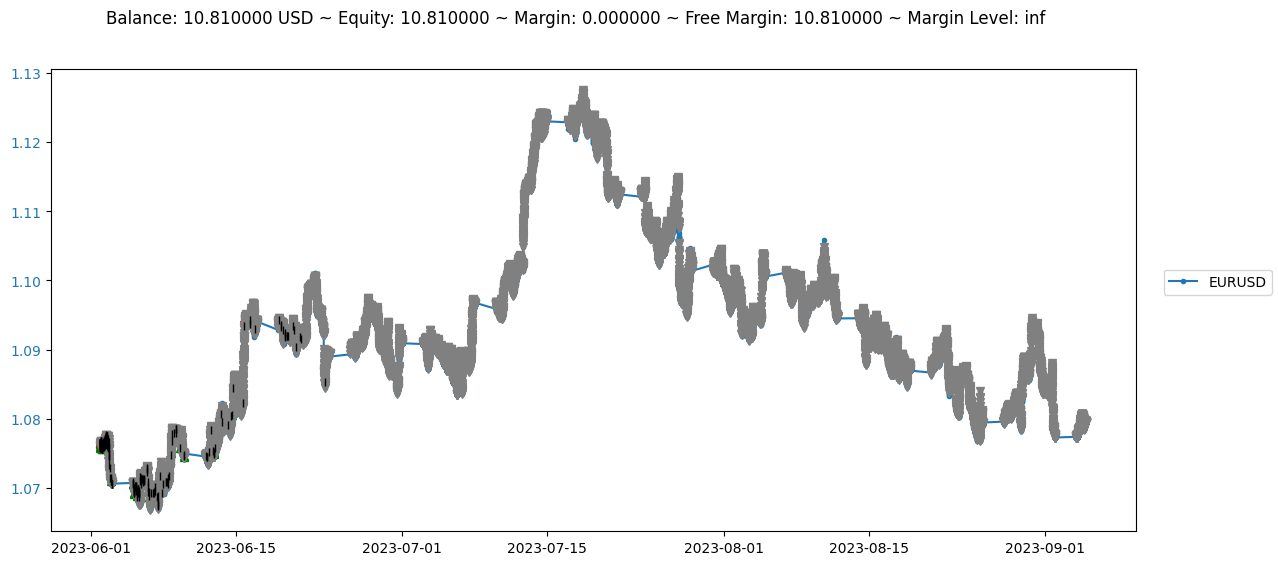

In [18]:
env.render('simple_figure')

## 6. Deploy

In [19]:
# https://www.mql5.com/en/docs/python_metatrader5

#### Đóng tiến trình

In [20]:
# shut down connection to MetaTrader 5
# mt5.shutdown()